In [238]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
from sys import modules
import seaborn as sns
from eval_utils import my_stupid_evaluation_function,mean_absolute_error
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

In [200]:
#Import Data 
X_data= pd.read_csv("/Users/eranbarlevy/Downloads/Regression_project_raz/data/X.csv")
y_data = pd.read_csv("/Users/eranbarlevy/Downloads/Regression_project_raz/data/y.csv")

#Set index
X_data = X_data.set_index('id')
y_data = y_data.set_index('id')

#join
df = X_data.join(y_data, on = 'id') 

#Copy
input_df = df

In [99]:
#Columns and type check
print(df.shape)
print(df.info())

(5363, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5363 entries, 2477 to 3572
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0.1         5363 non-null   int64  
 1   Unnamed: 0           5363 non-null   int64  
 2   Age                  5359 non-null   float64
 3   Gender               5359 non-null   object 
 4   Education Level      5360 non-null   object 
 5   Job Title            5361 non-null   object 
 6   Years of Experience  5360 non-null   float64
 7   Country              5363 non-null   object 
 8   Race                 5363 non-null   object 
 9   height               5363 non-null   float64
 10  weight               5361 non-null   float64
 11  professionalism      5360 non-null   float64
 12  Salary               5358 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 586.6+ KB
None


In [204]:
RATIO_KEEPER = 0.05
OUTLIER_DEFINITION = 3

gender_mapper = {"F":0,"M":1,"O":2}

#remove_outliers
def preprocess_df(df, ratio_keeper = 0.05, outlier_definition = 3):
    df = input_df.copy()

    #Removing some bad things:
    df = df.dropna()

    #df[(df["professionalism"] / df["Years of Experience"]).between(1-Ratio_keeper, 1+Ratio_keeper)] #What is 100%
    df = df[(df["professionalism"] / df["Years of Experience"]).between(5,60)]

    #df["Ratio"] = df["professionalism"] / df["Years of Experience"]
    #df["Age_Ratio"] = df["Ratio"] / df["Age"]
  
    #Age_Ratio_normad = (df['Age_Ratio']-df['Age_Ratio'].mean())/df['Age_Ratio'].std()
    #df = df[Age_Ratio_normad.between(-1 * outlier_definition, 1 * outlier_definition)]

    df["Gender"] = df["Gender"].map(gender_mapper) 

    one_hot_encoded = pd.get_dummies(df["Education Level"], prefix="Job")
    df = pd.concat([df, one_hot_encoded], axis=1)

    target_encoder = ce.TargetEncoder()
    df["Job Title Encoded"] = target_encoder.fit_transform(df["Job Title"], df["Salary"])

    #Drop Retendent Columns
    df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
    #Drop Category Column
    #df = df.drop(['Education Level', 'Job Title', "Country","Race"], axis=1)
    
    return df    

df = preprocess_df(input_df,"""RATIO_KEEPER = Ratio_keeper""", outlier_definition = OUTLIER_DEFINITION)

In [205]:
#Columns and type check
print(df.shape)
print(df.info())

(5266, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5266 entries, 2477 to 3572
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5266 non-null   float64
 1   Gender               5266 non-null   int64  
 2   Education Level      5266 non-null   object 
 3   Job Title            5266 non-null   object 
 4   Years of Experience  5266 non-null   float64
 5   Country              5266 non-null   object 
 6   Race                 5266 non-null   object 
 7   height               5266 non-null   float64
 8   weight               5266 non-null   float64
 9   professionalism      5266 non-null   float64
 10  Salary               5266 non-null   float64
 11  Job_bachelor         5266 non-null   uint8  
 12  Job_bachelor's|degr  5266 non-null   uint8  
 13  Job_high|scho        5266 non-null   uint8  
 14  Job_master           5266 non-null   uint8  
 15  Job_master's|degr    526

In [150]:
class MyModel:
    def __init__ (self, col):
        self.col = col

    def fit(self, X, y):
        
        #x and y are the ones from the training set
        self.col_salary_mapper_ = y.groupby(X[self.col]).mean().rename("y_hat") 
        self.fallback_salary_ = y.mean()

    def predict(self, X):
        """"We"""
        out = X.join(self.col_salary_mapper_, on = self.col)
        out = out["y_hat"]
        out = out.fillna(self.fallback_salary_) #what we didnt predict well will be in fallback price
        return out


In [106]:
""" 
class MyTransformer:
    
    #A transformer that transforms the column "col" from "raw" variant into standardized variant
    
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        self.avg_ = X[self.col].mean()
        self.std_ = X[self.col].std()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.col] = (X[self.col] - self.avg_) / self.std_
        # Apply your categorization logic for "Job Title" and "Education Level" here
        return X_transformed
    
column_transformer = MyTransformer(col = 'Age_Ratio')
column_transformer.fit(df)
"""

' \nclass MyTransformer:\n    \n    #A transformer that transforms the column "col" from "raw" variant into standardized variant\n    \n    def __init__(self, col):\n        self.col = col\n\n    def fit(self, X, y=None):\n        self.avg_ = X[self.col].mean()\n        self.std_ = X[self.col].std()\n        return self\n\n    def transform(self, X):\n        X_transformed = X.copy()\n        X_transformed[self.col] = (X[self.col] - self.avg_) / self.std_\n        # Apply your categorization logic for "Job Title" and "Education Level" here\n        return X_transformed\n    \ncolumn_transformer = MyTransformer(col = \'Age_Ratio\')\ncolumn_transformer.fit(df)\n'

In [206]:
df_train, df_test = train_test_split(df, random_state=1, test_size=0.2)
print(df_train.shape)
print(df_test.shape)
X_train, y_train = df_train.drop("Salary", axis=1), df_train["Salary"]
X_test, y_test = df_test.drop("Salary", axis=1), df_test["Salary"]

(4212, 18)
(1054, 18)


In [246]:
# Splitting the data into train and test sets
input_Splitting =  df
df = input_Splitting.copy()

X, y = df[['professionalism', "Years of Experience", "Job Title Encoded", "Job_bachelor"  ,"Job_bachelor's|degr"  ,"Job_high|scho"  ,"Job_master"  ,"Job_master's|degr" ,"Job_p"]], df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

print(df_train.shape)
print(df_test.shape)

(4212, 18)
(1054, 18)


In [251]:
score_board = {}
score_board_mse = {}
for col in X_train.columns:
    reg = MyModel(col = col)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    my_score = my_stupid_evaluation_function(y_test, y_pred, tolerance = 0.1)
    score_board[col] = my_score
  
    my_rmse = mean_squared_error(y_test, y_pred, squared=False)
    score_board_mse[col] = my_rmse

#Base evaluation funtion
pd.Series(score_board_mse), pd.Series(score_board)

(professionalism        22202.786476
 Years of Experience    26602.251645
 Job Title Encoded      29950.148277
 Job_bachelor           51405.049545
 Job_bachelor's|degr    46480.407413
 Job_high|scho          47880.105323
 Job_master             50813.649406
 Job_master's|degr      51201.951427
 Job_p                  45133.333878
 dtype: float64,
 professionalism        0.486717
 Years of Experience    0.359583
 Job Title Encoded      0.388046
 Job_bachelor           0.129981
 Job_bachelor's|degr    0.169829
 Job_high|scho          0.180266
 Job_master             0.140417
 Job_master's|degr      0.146110
 Job_p                  0.189753
 dtype: float64)

In [214]:
# Initialize your MyModel instance
model = MyModel(col="professionalism")

# Fit the MySuperModel on the training data
model.fit(X_train, y_train)

# Get the predicted y_hat values for train and test data
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

# Create new DataFrames with the predicted y_hat values as a feature
X_train_with_y_hat = X_train.copy()
X_train_with_y_hat["y_hat"] = y_hat_train

#Columns and type check

evaluation_train = pd.DataFrame(X_train_with_y_hat)
evaluation_train

X_test_with_y_hat = X_test.copy()
X_test_with_y_hat["y_hat"] = y_hat_test

evaluation_test = pd.DataFrame(X_test_with_y_hat)
evaluation_test

# Initialize a regression model (e.g., Linear Regression)
regressor = LinearRegression()

# Fit the regression model on the training data
regressor.fit(X_train_with_y_hat, y_train)

# Make predictions using the regression model on the test data
y_pred = regressor.predict(X_test_with_y_hat)

# Evaluate the regression model's performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Mean Squared Error: {rmse}")




Mean Squared Error: 18318.883653219735


In [212]:
model.col_salary_mapper_ 

professionalism
11.5       35000.000000
23.0       46823.571429
24.0       59685.361446
25.0       51754.901961
26.0       42058.823529
              ...      
1710.0    121450.000000
1728.0    192358.875000
1736.0    197354.000000
1881.0    188232.000000
2040.0    188651.000000
Name: y_hat, Length: 259, dtype: float64

In [213]:
my_score = my_stupid_evaluation_function(y_test, y_pred)
print(my_score)

0.538899430740038


In [215]:
class MySuperModel:
    def __init__(self, cols):
        """cols is a list of columns"""
        self.cols = cols

    def fit(self, X, y):
        # Combine X and y into a single DataFrame for easier handling
        combined_data = X.copy()
        combined_data["target"] = y

        # Drop rows with missing values in the specified columns
        combined_data.dropna(subset=self.cols + ["target"], inplace=True)

        # Calculate mean salaries based on the specified columns
        grouped = combined_data.groupby(self.cols)["target"].mean().reset_index()
        grouped.rename(columns={"target": "y_hat"}, inplace=True)

        self.col_salary_mapper_ = grouped.set_index(self.cols)
        self.fallback_salary_s_ = y.mean()

    def predict(self, X):
        """We can assume that X contains columns named self.cols"""
        # Merge with the salary mapper using specified columns
        out = X.merge(self.col_salary_mapper_, how='left', left_on=self.cols, right_index=True)
        
        # Fill missing values in "y_hat" column with fallback salary
        out["y_hat"] = out["y_hat"].fillna(self.fallback_salary_s_)
        return out["y_hat"]

# Initialize your MySuperModel instance
super_model = MySuperModel(cols=['professionalism',"Years of Experience","Job_bachelor"  ,"Job_bachelor's|degr"  ,"Job_high|scho"  ,"Job_master"  ,"Job_master's|degr" ,"Job_p"])

# Assuming you have X_train, y_train, X_test, and y_test with no missing values
# Fit the MySuperModel on the training data
super_model.fit(X_train, y_train)

# Get the predicted y_hat values for train and test data
y_hat_train = super_model.predict(X_train)
y_hat_test = super_model.predict(X_test)

# Create new DataFrames with the predicted y_hat values as a feature
X_train_with_y_hat = X_train.copy()
X_train_with_y_hat["y_hat"] = y_hat_train

X_test_with_y_hat = X_test.copy()
X_test_with_y_hat["y_hat"] = y_hat_test

# Initialize a regression model (e.g., Linear Regression)
regressor = LinearRegression()

# Fit the regression model on the training data
regressor.fit(X_train_with_y_hat, y_train)

# Make predictions using the regression model on the test data
y_pred = regressor.predict(X_test_with_y_hat)

# Evaluate the regression model's performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Mean Squared Error: {rmse}")


Mean Squared Error: 18449.41314529508


In [216]:
super_model.col_salary_mapper_ 

y_hat
professionalism Years of Experience Job_bachelor Job_bachelor's|degr Job_high|scho Job_master Job_master's|degr Job_p               
11.5            1.5                 1            0                   0             0          0                 0       35000.000000
23.0            2.0                 0            0                   0             0          0                 1         579.000000
                                                                     1             0          0                 0       30500.000000
                                                 1                   0             0          0                 0       45210.526316
                                    1            0                   0             0          0                 0       90000.000000
...                                                                                                                              ...
1736.0          33.0                0            0                   0             0          0                 1      197354.000000
1881.0          34.0                0            0                   0             0          1                 0      188232.000000
                35.0                0            0                   0             0          1                 0      188232.000000
2040.0          35.0                0            0                   0             0          0                 1      188651.000000
                36.0                0            0                   0             0          0                 1      188651.000000

[950 rows x 1 columns]

In [217]:
my_score = my_stupid_evaluation_function(y_test, y_pred)
print(my_score)

0.6593927893738141


In [252]:
from itertools import combinations

score_board = {}
score_board_mse = {}

# Iterate through all possible combinations of columns
for num_cols in range(1, len(X_train.columns) + 1):
    for col_combo in combinations(X_train.columns, num_cols):
        reg = MySuperModel(cols=list(col_combo))
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        my_score = my_stupid_evaluation_function(y_test, y_pred, tolerance = 0.1)
        score_board[col_combo] = my_score
        print(f"Columns: {col_combo}, My Score: {my_score:.4f}")

Columns: ('professionalism',), My Score: 0.4867
Columns: ('Years of Experience',), My Score: 0.3596
Columns: ('Job Title Encoded',), My Score: 0.3880
Columns: ('Job_bachelor',), My Score: 0.1300
Columns: ("Job_bachelor's|degr",), My Score: 0.1698
Columns: ('Job_high|scho',), My Score: 0.1803
Columns: ('Job_master',), My Score: 0.1404
Columns: ("Job_master's|degr",), My Score: 0.1461
Columns: ('Job_p',), My Score: 0.1898
Columns: ('professionalism', 'Years of Experience'), My Score: 0.4545
Columns: ('professionalism', 'Job Title Encoded'), My Score: 0.8340
Columns: ('professionalism', 'Job_bachelor'), My Score: 0.5731
Columns: ('professionalism', "Job_bachelor's|degr"), My Score: 0.5436
Columns: ('professionalism', 'Job_high|scho'), My Score: 0.5019
Columns: ('professionalism', 'Job_master'), My Score: 0.5085
Columns: ('professionalism', "Job_master's|degr"), My Score: 0.5446
Columns: ('professionalism', 'Job_p'), My Score: 0.5161
Columns: ('Years of Experience', 'Job Title Encoded'), M

In [253]:
#Base evaluation funtion
best_combination = max(score_board, key=score_board.get)
best_score = score_board[best_combination]

print(f"Best Combination: {best_combination}, Best Score: {best_score:.4f}")

Best Combination: ('professionalism', 'Job Title Encoded', "Job_bachelor's|degr"), Best Score: 0.8472


In [254]:
#reg = MySuperModel(cols = ['professionalism', "Years of Experience", "Job Title Encoded"]) #23529
reg = MySuperModel(cols = ['professionalism', 'Job Title Encoded', "Job_bachelor's|degr"]) #19494
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)

rmse = mean_squared_error(y_test, y_pred, squared=False) 
rmse

19494.119273949662

21645.42453698366


<Axes: xlabel='y_test', ylabel='y_pred'>

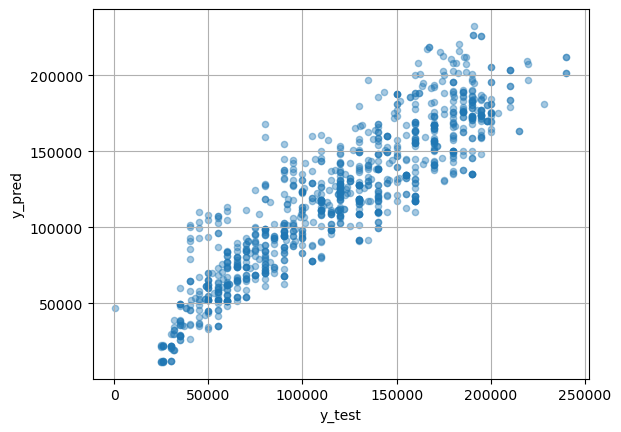

In [223]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(rmse)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

20108.06821150977


<Axes: xlabel='y_test', ylabel='y_pred'>

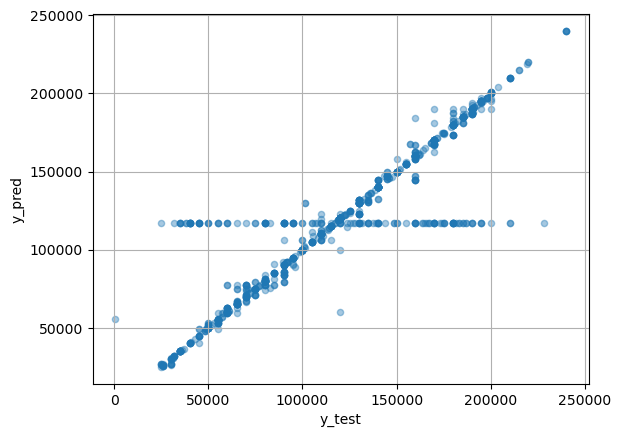

In [227]:
reg = MySuperModel(cols = ['professionalism',"Job Title Encoded","Job_bachelor"  ,"Job_bachelor's|degr"  ,"Job_high|scho"  ,"Job_master"  ,"Job_master's|degr" ,"Job_p"])
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(rmse)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

7785.044366761032


<Axes: xlabel='y_test', ylabel='y_pred'>

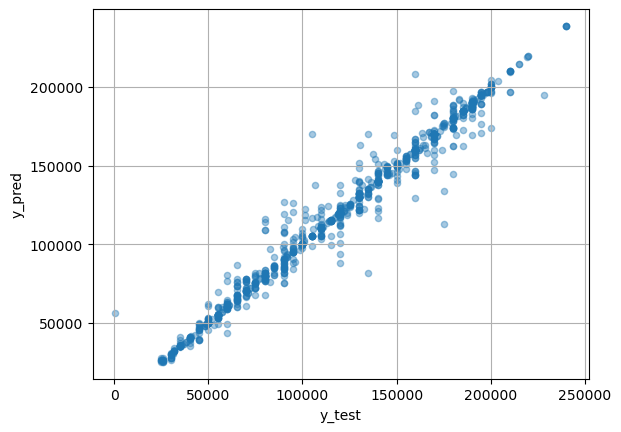

In [244]:
#7770
model = RandomForestRegressor(max_depth=20)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(rmse)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

8540.013022950445


<Axes: xlabel='y_test', ylabel='y_pred'>

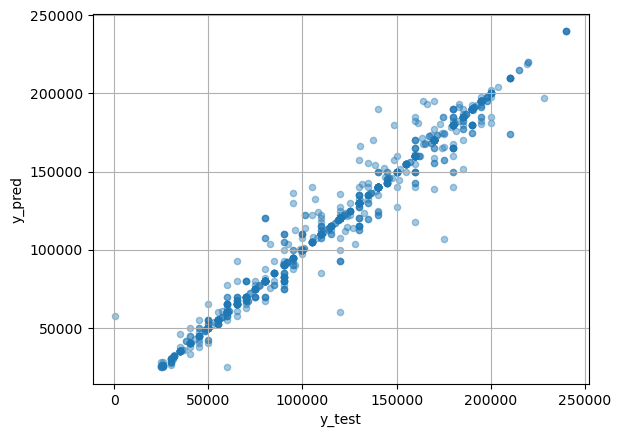

In [237]:
model = KNeighborsRegressor(n_neighbors=2, p=2)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(rmse)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

In [255]:
# Splitting the data into train and test sets
input_Splitting =  df
df = input_Splitting.copy()

X, y = df[['professionalism', 'Job Title Encoded', "Job_bachelor's|degr"]], df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

print(df_train.shape)
print(df_test.shape)

(4212, 18)
(1054, 18)


24804.398886322357


<Axes: xlabel='y_test', ylabel='y_pred'>

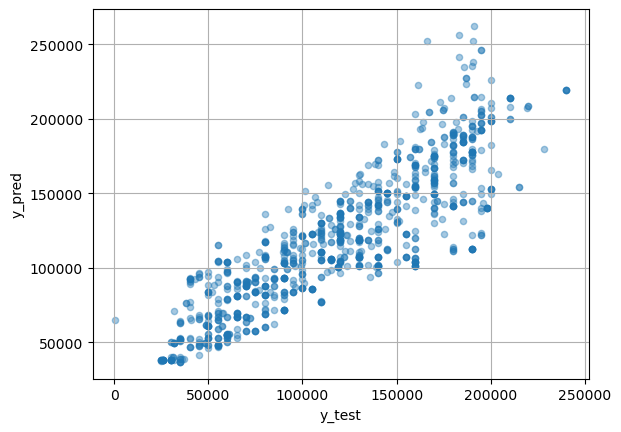

In [256]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(rmse)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

8431.600722722962


<Axes: xlabel='y_test', ylabel='y_pred'>

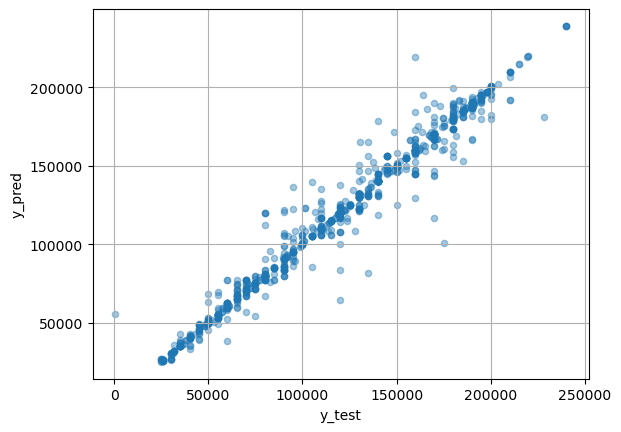

In [259]:
model = RandomForestRegressor(max_depth=40)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(rmse)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

9317.036574845131


<Axes: xlabel='y_test', ylabel='y_pred'>

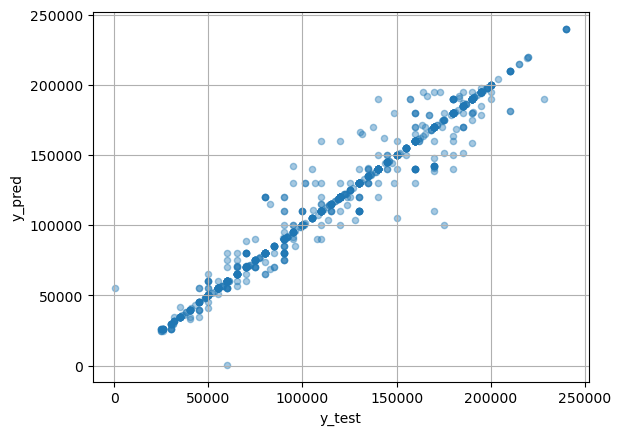

In [263]:
model = KNeighborsRegressor(n_neighbors=1, p=2)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(rmse)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

In [268]:
# Splitting the data into train and test sets
input_Splitting =  df
df = input_Splitting.copy()

X, y = df[['professionalism', "Years of Experience", "Job Title Encoded", "Job_bachelor"  ,"Job_bachelor's|degr"  ,"Job_high|scho"  ,"Job_master"  ,"Job_master's|degr" ,"Job_p"]], df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

print(df_train.shape)
print(df_test.shape)

(4212, 18)
(1054, 18)


In [274]:
class MySuperModel:
    def __init__(self, cols):
        """cols is a list of columns"""
        self.cols = cols

    def fit(self, X, y):
        # Combine X and y into a single DataFrame for easier handling
        combined_data = X.copy()
        combined_data["target"] = y

        # Drop rows with missing values in the specified columns
        combined_data.dropna(subset=self.cols + ["target"], inplace=True)

        # Calculate mean salaries based on the specified columns
        grouped = combined_data.groupby(self.cols)["target"].mean().reset_index()
        grouped.rename(columns={"target": "y_hat"}, inplace=True)

        self.col_salary_mapper_ = grouped.set_index(self.cols)
        self.fallback_salary_s_ = y.mean()

    def predict(self, X):
        """We can assume that X contains columns named self.cols"""
        # Merge with the salary mapper using specified columns
        out = X.merge(self.col_salary_mapper_, how='left', left_on=self.cols, right_index=True)
        
        # Fill missing values in "y_hat" column with fallback salary
        out["y_hat"] = out["y_hat"].fillna(self.fallback_salary_s_)
        return out["y_hat"]

# Initialize your MySuperModel instance
super_model = MySuperModel(cols=['professionalism',"Years of Experience","Job_bachelor"  ,"Job_bachelor's|degr"  ,"Job_high|scho"  ,"Job_master"  ,"Job_master's|degr" ,"Job_p"])

# Assuming you have X_train, y_train, X_test, and y_test with no missing values
# Fit the MySuperModel on the training data
super_model.fit(X_train, y_train)

# Get the predicted y_hat values for train and test data
y_hat_train = super_model.predict(X_train)
y_hat_test = super_model.predict(X_test)

# Create new DataFrames with the predicted y_hat values as a feature
X_train_with_y_hat = X_train.copy()
X_train_with_y_hat["y_hat"] = y_hat_train

X_test_with_y_hat = X_test.copy()
X_test_with_y_hat["y_hat"] = y_hat_test

# Initialize a regression model (e.g., Linear Regression)
regressor = KNeighborsRegressor(n_neighbors=5, p=2)

# Fit the regression model on the training data
regressor.fit(X_train_with_y_hat, y_train)

# Make predictions using the regression model on the test data
y_pred = regressor.predict(X_test_with_y_hat)

# Evaluate the regression model's performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Mean Squared Error: {rmse}")

Mean Squared Error: 17365.714607548285
